In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os 
import sys
from datetime import datetime, timedelta
from modeling.utils import process_address
from modeling.utils import * 
import json
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [2]:
# daily_scrpe_folder = '/home/user/DataCenter/HAR_data/combined_pickles/'
# [_ for _ in sorted(os.listdir(daily_scrpe_folder)) if "sale" in _]
# df1 = pd.read_pickle(daily_scrpe_folder + "zipcode_search__2020_10_31_for_sale.pkl")
# df2 = pd.read_pickle(daily_scrpe_folder + "zipcode_search__2023_11_04_for_sale.pkl")

In [3]:
df = pd.read_pickle("../../data/property_structured_10312020text_only_12162024_train.pkl")

In [4]:
len(df)

671672

<Axes: >

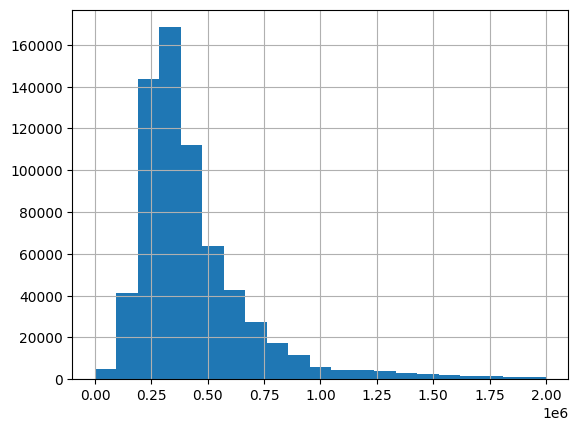

In [5]:
df["price"].hist(range=(0, 2e6), bins=21)

In [6]:
display_cols = ["date", "status", "price", "building_sqft2", "num_beds", "num_bath", "address_key"]
# df[(df["price"] < 1e5) &(df["building_sqft2"] > 2000)]
df[df["price"] > 2.5e6][display_cols]

,date,status,price,building_sqft2,num_beds,num_bath,address_key
47,2023_11_05,Under Contract - P,3995950.0,8649.0,5.0,0.0,"11103 Memorial Drive, Houston, TX 77024"
301,2023_11_06,Under Contract - P,5295000.0,NaN,6.0,0.0,"11125 N Country Squire, Houston, TX 77024"
590,2023_11_07,Under Contract - P,4995000.0,5716.0,5.0,0.0,"1750 Dalton Rd, Rockwall, TX 75087"
1034,2023_11_10,Under Contract - P,2900000.0,7709.0,5.0,0.0,"5615 Stone Cliff Ct, Dallas, TX 75287"
1534,2023_11_11,Under Contract - P,3998800.0,9000.0,6.0,0.0,"39 Haven Shore Ln, Sugar Land, TX 77479"
...,...,...,...,...,...,...,...
112,2023_11_03,Under Contract - P,5470000.0,4210.0,3.0,0.0,"2419 Mimosa Street #801, Houston, TX 77019"
326,2023_11_03,Under Contract - OP,2750000.0,5741.0,5.0,0.0,"17709 Navigation Ln, Jonestown, TX 78645"
89,2023_11_03,Under Contract - P,2695000.0,3566.0,4.0,0.0,"5300 N Scout Island Cir, Austin, TX 78731"
125,2023_11_03,Under Contract - OP,2750000.0,8240.0,5.0,0.0,"7812 Valburn Dr, Austin, TX 78731"


## Select the time window to extract house information

In [2]:
cache_file = "../../data/daily_df_cache.pkl"

if os.path.exists(cache_file):
    daily_df = pd.read_pickle(cache_file)
else: 
    daily_scrpe_folder = '/home/user/DataCenter/HAR_data/combined_pickles/'
    start_date = datetime(2020, 10, 31)
    end_date = datetime(2023, 11,4)
    daily_df = None 
    
    for day in tqdm(range((end_date - start_date).days + 1)):
        cur_date = start_date + timedelta(days=day)
        date_str = cur_date.strftime("%Y_%m_%d")
        date_month = cur_date.strftime("%Y_%m")
        daily_pickle = os.path.join(daily_scrpe_folder, "zipcode_search__"+date_str+"_for_sale.pkl")
        try:
            if daily_df is None:
                daily_df = pd.read_pickle(daily_pickle)
                daily_df = daily_df[daily_df["status"].apply(lambda x: "contract" in x.lower())]
                daily_df["address_key"] = daily_df["address"].apply(lambda x: process_address(x))
                daily_df["date"] = date_str
                daily_df["date_month"] = date_month
            else:
                tem_df = pd.read_pickle(daily_pickle)
                tem_df = tem_df[tem_df["status"].apply(lambda x: "contract" in x.lower())]
                tem_df["address_key"] = tem_df["address"].apply(lambda x: process_address(x))
                tem_df["date"] = date_str
                tem_df["date_month"] = date_month
                daily_df = pd.concat([daily_df, tem_df], axis=0)\
                            .drop_duplicates(["address","date_month"] , keep="last")
        except:
            pass 
    
    raw_df = pd.read_pickle("../../data/property_structured_12162024.pkl").reset_index(drop=True)
    train_address_key_set = set(raw_df["address_key"].values)
    print(len(daily_df))
    daily_df = daily_df[(daily_df["address_key"].apply(lambda x: x not in train_address_key_set)) | (daily_df["date"] < "2023_06_01")]
    print(len(daily_df))
    daily_df = daily_df.drop_duplicates("address_key", keep="last")
    daily_df.to_pickle(cache_file)
print(len(daily_df))
daily_df.head(2)

512129


,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,num_half_bath,building_sqft,has_loft,num_stories,num_parking_space,address_key,date,date_month
271,"9816 Havenway Dr, Denton, TX 76226",https://www.har.com//homedetail/9816-havenway-...,"4 Bed(s) 2 Full Bath(s) 1 Stories 2,048 Build...","Frankie Arthur WORK FOR Coldwell Banker Apex, ...",309000.0,8.0,Under Contract - Pending,76226,4,2,0,2048,0,1,0,"9816 Havenway Dr, Denton, TX 76226",2020_10_31,2020_10
54,"4028 Azure Ln, Addison, TX 75001",https://www.har.com//homedetail/4028-azure-ln-...,"3 Bed(s) 2 Full Bath(s) 1 Stories 1,980 Build...",David Heape WORK FOR Keller Williams Realty DPR,419000.0,55.0,Under Contract - Pending,75001,3,2,0,1980,0,1,0,"4028 Azure Ln, Addison, TX 75001",2020_10_31,2020_10


In [3]:
raw_df_addresses = set(pd.read_pickle("../../data/property_structured_12162024.pkl")["address_key"].values)
print(len(daily_df))
daily_df = daily_df[daily_df["address_key"].apply(lambda x: x not in raw_df_addresses)]
print(len(daily_df))

512129
502627


## Append full house json file 

In [4]:
json_folder = "/home/user/DataCenter/HAR_data/address_fullinfo_for_sale/"
all_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith(".json")]
json_path_df = pd.DataFrame(all_files, columns=["json_path"])
json_path_df["address"] = json_path_df["json_path"].apply(lambda x: x.split("/")[-1][:-16])
json_path_df["time_epoch"] = json_path_df["json_path"].apply(lambda x: x.split("/")[-1][-15:-5])
print(len(json_path_df))
json_path_df = json_path_df.sort_values("time_epoch").drop_duplicates("address", keep="last")
print(len(json_path_df))
json_path_df.sample(3)

1712773
1337407


,json_path,address,time_epoch
57176,/home/user/DataCenter/HAR_data/address_fullinf...,"3810 Sullivan Spur Court, Katy, TX 77494",1645479015
800385,/home/user/DataCenter/HAR_data/address_fullinf...,"2711 Blackbuck Ct, Crandall, TX 75114",1710388142
53401,/home/user/DataCenter/HAR_data/address_fullinf...,"5810 Turmeric Dr, Baytown, TX 77521",1719720812


In [5]:
join_df = daily_df.join(json_path_df.set_index("address"), on="address", how="inner")
print(len(join_df))
join_df.head(2)

502104


,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,num_half_bath,building_sqft,has_loft,num_stories,num_parking_space,address_key,date,date_month,json_path,time_epoch
271,"9816 Havenway Dr, Denton, TX 76226",https://www.har.com//homedetail/9816-havenway-...,"4 Bed(s) 2 Full Bath(s) 1 Stories 2,048 Build...","Frankie Arthur WORK FOR Coldwell Banker Apex, ...",309000.0,8.0,Under Contract - Pending,76226,4,2,0,2048,0,1,0,"9816 Havenway Dr, Denton, TX 76226",2020_10_31,2020_10,/home/user/DataCenter/HAR_data/address_fullinf...,1600399380
54,"4028 Azure Ln, Addison, TX 75001",https://www.har.com//homedetail/4028-azure-ln-...,"3 Bed(s) 2 Full Bath(s) 1 Stories 1,980 Build...",David Heape WORK FOR Keller Williams Realty DPR,419000.0,55.0,Under Contract - Pending,75001,3,2,0,1980,0,1,0,"4028 Azure Ln, Addison, TX 75001",2020_10_31,2020_10,/home/user/DataCenter/HAR_data/address_fullinf...,1598049671


## Append Image Folder 

In [6]:
image_folder = "/home/user/DataCenter/HAR_data/house_images/"
all_folders = []
for i in tqdm(range(100)):
    for j in range(100):
        folder = os.path.join(image_folder, f"{i:04d}/{j:04d}") 
        all_folders.extend([os.path.join(folder, f) for f in os.listdir(folder)])


00%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.86it/s]

In [7]:
image_df = pd.DataFrame(all_folders, columns=["image_path"])
image_df["address"] = image_df["image_path"].apply(lambda x: x.split("/")[-1][:-11])
image_df["time_epoch"] = image_df["image_path"].apply(lambda x: x.split("/")[-1][-10:])
print(len(image_df))
image_df = image_df.sort_values("time_epoch").drop_duplicates("address", keep="last")
print(len(image_df))
image_df.sample(2)

775036
772274


,image_path,address,time_epoch
607003,/home/user/DataCenter/HAR_data/house_images/00...,"2221 W Dallas St #0376, Houston, TX 77019",1730752529
39199,/home/user/DataCenter/HAR_data/house_images/00...,"370 Cistern Way, Austin, TX 78737",1734900478


In [8]:
# join_df.to_pickle("../../data/tem.pkl")

In [9]:
print(len(join_df))
join_df2 = join_df.join(image_df.set_index("address")[["image_path"]], on="address", how="inner")
print(len(join_df2))
join_df2.head(2)

502104
301026


,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,num_half_bath,building_sqft,has_loft,num_stories,num_parking_space,address_key,date,date_month,json_path,time_epoch,image_path
271,"9816 Havenway Dr, Denton, TX 76226",https://www.har.com//homedetail/9816-havenway-...,"4 Bed(s) 2 Full Bath(s) 1 Stories 2,048 Build...","Frankie Arthur WORK FOR Coldwell Banker Apex, ...",309000.0,8.0,Under Contract - Pending,76226,4,2,0,2048,0,1,0,"9816 Havenway Dr, Denton, TX 76226",2020_10_31,2020_10,/home/user/DataCenter/HAR_data/address_fullinf...,1600399380,/home/user/DataCenter/HAR_data/house_images/00...
54,"4028 Azure Ln, Addison, TX 75001",https://www.har.com//homedetail/4028-azure-ln-...,"3 Bed(s) 2 Full Bath(s) 1 Stories 1,980 Build...",David Heape WORK FOR Keller Williams Realty DPR,419000.0,55.0,Under Contract - Pending,75001,3,2,0,1980,0,1,0,"4028 Azure Ln, Addison, TX 75001",2020_10_31,2020_10,/home/user/DataCenter/HAR_data/address_fullinf...,1598049671,/home/user/DataCenter/HAR_data/house_images/00...


In [10]:
# join_df2["date"].unique()

In [11]:
join_df2[["address", "json_path", "image_path"]].sample(1).iloc[0].values

array(['4713 Lido Ln, Houston, TX 77092',
       '/home/user/DataCenter/HAR_data/address_fullinfo_for_sale/4713 Lido Ln, Houston, TX 77092_1691706414.json',
       '/home/user/DataCenter/HAR_data/house_images/0089/0027/4713 Lido Ln, Houston, TX 77092_1733677704'],
      dtype=object)

In [12]:
## Strategy to drop the redudant addresses, chooose the one with largest json size, and the most images in the folder
# join_df2["json_size"] = join_df2["json_path"].apply(lambda x: os.path.getsize(x))

In [13]:
# join_df2["image_cnt"] = join_df2["image_path"].apply(lambda x: len([_ for _ in os.listdir(x) if _.endswith(".jpeg")]))

In [14]:
## Defer the drop duplicates to the end
final_df = join_df2#.sort_values(["json_size", "image_cnt"]).drop_duplicates("address_key", keep="last")
print(len(final_df), len(join_df2))

301026 301026


## Get feature processing from json file

In [20]:
def read_json(json_path):
    with open(json_path) as f:
        return json.load(f)

processed_df = []
n_rows = len(final_df)
batch_size = 5000
n_batches = (n_rows + batch_size - 1)// batch_size

for batch_i in tqdm(range(n_batches)):
    sample_df = final_df.iloc[batch_i * batch_size: (batch_i + 1) * batch_size]
    sample_df["content"] = sample_df["json_path"].apply(read_json)
    sample_df["LAT"], sample_df["LON"] = zip(*sample_df["content"].apply(lambda x: get_lon_lat(x["coords"][0], x["coords"][1])))
    sample_df["building_sqft2"] = sample_df["content"].apply(lambda x: parse_built_Sqft(x))
    sample_df["building_sqft"] = sample_df.apply(lambda x: x["building_sqft2"] if np.isnan(x["building_sqft2"]) is False else x["building_sqft"], axis=1)
    sample_df["Lot Size"] = sample_df["content"].apply(lambda x: parse_lot_size(x)[0])
    sample_df["Year Built"] = sample_df["content"].apply(lambda x: parse_built_year(x)[0])
    sample_df["Garage Number"] = sample_df["content"].apply(lambda x: get_garage_num(x))
    sample_df["Bedrooms"] = sample_df["content"].apply(lambda x: parse_bedroom(x))
    sample_df["Baths"] = sample_df["content"].apply(lambda x: parse_bath(x))
    sample_df["Maintenance Fee"] = sample_df["content"].apply(lambda x: parse_maintenance_fee(x))
    sample_df["Tax Rate"] = sample_df["content"].apply(lambda x: extract_tax_rate_tax_table(x["house_tax_table"]))
    sample_df["tax_rate2"] = sample_df["content"].apply(get_tax_rate)
    sample_df.loc[sample_df["Tax Rate"].isnull(), "Tax Rate"] = sample_df.loc[sample_df["Tax Rate"].isnull(), "tax_rate2"]
    sample_df["Recent Market Value"] = sample_df["content"].apply(lambda x: get_recent_market_value(x))
    sample_df["Recent Tax Value"] = sample_df["content"].apply(lambda x: get_recent_tax_value(x))
    sample_df["Property Type"] = sample_df["content"].apply(lambda x: parse_property_type(x))
    sample_df["County"] = sample_df["content"].apply(lambda x: x["house_features"]["County:"] if "County:" in x["house_features"] else None)
    sample_df["Private Pool"] = sample_df["content"].apply(lambda x: private_pool_feature(x))
    sample_df["Area Pool"] = sample_df["content"].apply(lambda x: area_pool_feature(x))
    sample_df["Private_pool_desc"] = sample_df["content"].apply(lambda x: private_pool_desc_feature(x))
    sample_df["Pool_feature_multiclass"] = sample_df["content"].apply(lambda x: private_pool_multiclass_feature(x))
    sample_df["Foundation_multiclass"] = sample_df["content"].apply(lambda x: Foundation_multiclass_feature(x))
    sample_df["Garage Types_multiclass"] = sample_df["content"].apply(lambda x: Garage_Types_multiclass_features(x))
    sample_df["Roof Type_multiclass"] = sample_df["content"].apply(lambda x: Roof_Type_multiclass(x))
    sample_df["floor_type_multiclass"] = sample_df["content"].apply(lambda x: floor_type_multiclass(x))
    sample_df["Exterior Type_multiclass"] = sample_df["content"].apply(lambda x: exterior_type_multiclass(x))
    sample_df["Exterior_multiclass"] = sample_df["content"].apply(lambda x: exterior_multiclass(x))
    sample_df["Style_multiclass"] = sample_df["content"].apply(lambda x: style_multiclass(x))
    sample_df["finance_option_multiclass"] = sample_df["content"].apply(lambda x: finanace_option_multiclass(x))
    sample_df["high_school_star"] = sample_df["content"].apply(lambda x: extract_high_school_name(x["house_schools"])[2] if "house_schools" in x else np.nan)
    sample_df["middle_school_star"] = sample_df["content"].apply(lambda x: extract_mid_school_name(x["house_schools"])[2] if "house_schools" in x else np.nan)
    sample_df["elementary_school_star"] = sample_df["content"].apply(lambda x: extract_elemetary_school_name(x["house_schools"])[2] if "house_schools" in x else np.nan)
    sample_df["school_org"] = sample_df["content"].apply(lambda x: school_org(x))
    sample_df["general_desc"] = sample_df["content"].apply(lambda x: x["general_desc"] if "general_desc" in x else None)
    sample_df = sample_df.drop(columns=["content"])
    processed_df.append(sample_df)


00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [04:43<00:00,  6.75s/it]

In [21]:
processed_final_df = pd.concat(processed_df)

In [22]:
processed_final_df_filtered = processed_final_df.drop_duplicates(subset=["address_key"], keep="first")

In [23]:
raw_df_addresses = set(pd.read_pickle("../../data/property_structured_12162024.pkl")["address_key"].values)
print(len(processed_final_df_filtered))
processed_final_df_filtered = processed_final_df_filtered[processed_final_df_filtered["address_key"].apply(lambda x: x not in raw_df_addresses)]
print(len(processed_final_df_filtered))

208470
208470


In [24]:
# processed_final_df_filtered.sample(3)

## Run Text encoding and Image encoding

In [15]:
## Get the list of images to be encoded
def get_image_paths(image_folder, check_mean=False):
    images_path = [os.path.join(image_folder, f_) for f_ in os.listdir(image_folder) if f_.endswith(".jpeg")]
    n_images = len(images_path)
    if check_mean:
        images_path = [f_ for f_ in images_path if os.path.exists(f_.replace(".jpeg", "mean.pt")) is False] 
    else:
        images_path = [f_ for f_ in images_path if os.path.exists(f_.replace(".jpeg", ".pt")) is False]
    return images_path, n_images 

batch_size = 2048 
n_batches = len(processed_final_df_filtered) // batch_size + 1
all_img_cnt = 0
all_img_paths = []

for batch_i in tqdm(range(n_batches)):
    with Pool(10) as p:
        img_path, img_cnt = zip(*p.map(get_image_paths, processed_final_df_filtered["image_path"].iloc[batch_i * batch_size: (batch_i + 1) * batch_size].values))
    [all_img_paths.extend(path_) for path_ in img_path]
    all_img_cnt += sum(img_cnt)
print(len(all_img_paths))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [01:19<00:00,  1.85it/s]

404577


In [16]:
## Run DINO Encoding
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

device = "cuda:0"
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')
model = AutoModel.from_pretrained('facebook/dinov2-small')
model.cuda(device)

def read_image(image_path):
    image = Image.open(image_path)
    return image

In [ ]:
batch_size = 1024 
n_batches = (len(all_img_paths) + batch_size - 1) // batch_size
with Pool(10) as p:
    for batch_i in tqdm(range(n_batches)):
        batch_images = all_img_paths[batch_i * batch_size: batch_i * batch_size + batch_size]
        
        inp_imgs = p.map(read_image, batch_images)
        inputs = processor(images=inp_imgs, return_tensors="pt").to(device, non_blocking=True)
        with torch.no_grad():
            last_hidden_states = model(**inputs)[0]
            embedding_list = last_hidden_states[:, 0, :].cpu()
            mean_embedding_list = torch.mean(last_hidden_states, axis=1).cpu()
        embedding_list = [e.clone() for e in embedding_list]
        # mean_embedding_list = [e.clone() for e in mean_embedding_list]
        _ = [torch.save(embedding_list[i], batch_images[i].replace(".jpeg", ".pt")) for i in range(len(embedding_list))]
    # _ = [torch.save(mean_embedding_list[i], batch_images[i].replace(".jpeg", "mean.pt")) for i in range(len(embedding_list))]

  1%|▍                                                                                              | 2/396 [00:20<1:06:18, 10.10s/it]

In [ ]:
def load_and_stack_tensor(image_folder, use_mean_tensor=False):
    if use_mean_tensor:
        pt_paths = [os.path.join(image_folder, f_) for f_ in os.listdir(image_folder) if f_.endswith("mean.pt")]
    else: 
        pt_paths = [os.path.join(image_folder, f_) for f_ in os.listdir(image_folder) if f_.endswith(".pt") and "mean" not in f_]
    if len(pt_paths) == 0:
        return np.zeros(384)
    pt_list = np.array([torch.load(pt_path).numpy() for pt_path in pt_paths])
    return np.mean(pt_list, axis=0)

with Pool(10) as p:
    image_dinov2s_cls_mean = p.map(load_and_stack_tensor, processed_final_df_filtered["image_path"].values)

In [ ]:
processed_final_df_filtered["img_emb"] = image_dinov2s_cls_mean

#### Text Embedding

In [15]:
from transformers import pipeline
feature_extraction = pipeline('feature-extraction', model="roberta-base", tokenizer="roberta-base", device=1, truncation=True)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [18]:
cnt = 0 
general_desc_mean_features = []
for desc in tqdm(processed_final_df_filtered["general_desc"].values):
    if desc is None:
        cnt += 1
        general_desc_mean_features.append(np.zeros(768))
    else: 
        feature = feature_extraction(desc,  return_tensors="pt")
        general_desc_mean_features.append(np.mean(feature[0].clone().numpy(), axis=0))
processed_final_df_filtered["general_desc_roberta_mean_features"] = general_desc_mean_features

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502104/502104 [2:14:35<00:00, 62.18it/s]

In [ ]:
# processed_final_df_filtered.to_pickle("../../data/property_structured_10312020_11042023_p1.pkl")

In [ ]:
# path = "../../data/property_structured_12162024_tabformer_t32c.pt"
# def read_column_name_and_stats(path):
#     with open(path, "rb") as f:
#         _, col_stats = torch.load(f)
#     col_names = list(col_stats.keys())
#     return col_names, col_stats
# col_names, col_stats = read_column_name_and_stats(path)

In [ ]:
# processed_final_df_filtered[col_names].sample(3)

## Combine tables

In [19]:
df1 = pd.read_pickle("../../data/property_structured_12162024_train.pkl")
df2 = processed_final_df_filtered
# df2 = pd.read_pickle("../../data/property_structured_10312020_11042023_p1.pkl")

In [20]:
len(df1), len(df2)

(169568, 502104)

In [21]:
cols1 = df1.columns.values
cols2 = df2.columns.values

In [22]:
set(cols1) - set(cols2), set(cols2) - set(cols1)

({'image_cnt',
  'image_path',
  'img_emb',
  'json_size',
  'pool_desc_roberta_mean_features'},
 {'date_month'})

In [23]:
cols = list(set(cols1).intersection(cols2))
final_df = pd.concat([df1[cols], df2[cols]], axis=0)

In [24]:
final_df.to_pickle("../../data/property_structured_10312020text_only_12162024_train.pkl")